In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_json('food_enforcement_US_bacteria.json', orient='records')

In [3]:
print(raw_data.shape)
# print(raw_data.head(10).product_description)

(6104, 26)


### Bag of words feature representation for descriptive text

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words = 'english') #increased ngram range to encompass 2-word phrases which could better capture food and brand names, employed 'english' stopwords to limit effects of unhelpfully common words 

corpus = raw_data['product_description']
X = vectorizer.fit_transform(corpus)

transformer_cv = TfidfTransformer(sublinear_tf=True) #applied transformer to vectorized dataset
X = transformer_cv.fit_transform(X)

X.shape

(6104, 60367)

### fit Kmeans

The code in the cell below was borrowed from option 1 (elbow plot).

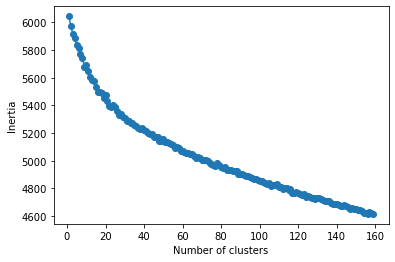

In [7]:
# first attempt at fitting K means to view change in Inertia
from sklearn.cluster import KMeans

# container to store inertia scores over iterations
distortions = []

# fit KMeans iteratively to begin to assess the appropriate number of clusters
for i in range(1, 160):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)
    
# vizualize change in inertia
plt.plot(range(1, 160), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Looking at the elbow plot above, I decided that the elbow point seemed to occur around 140 clusters. After trying a few close-by iterations, I settled on 145 as the number of clusters. I thought it would be more useful for the algorithm to group things more narrowly, by closely-related products like 'ice cream' or 'cheese', instead of broad categories like just 'meats' or 'dairy' because I think in terms of seeing which kinds of foods end up being dangerous the most, it helps to have that more specific perspective (especially in figuring out what to avoid when I'm in the grocery store, lest I be unable to purchase anything at all!). Looking at the cells below as well, where certain brands seem to have more...problems than others, it could be helpful to down-select by that brand so as to avoid it in the future, just in case.

In [8]:
#fit Kmeans with k clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=145,n_init=50)
km.fit(X)

KMeans(n_clusters=145, n_init=50)

### labels are named with integers and stored in the `labels_` attribute

In [9]:
km.labels_

array([  8,  98, 118, ..., 128, 132, 132], dtype=int32)

### take a look at one of the cluster results

The following cell iterates through all the 145 clusters, where each item is separated by the stars ('***') and each cluster is separated by dashes ('---') and with the cluster number listed at the beginning fo the cluster. One interesting thing about the clusters is that the name of a brand such as 'Blue Bell' or 'UPC' pulled things into separate clusters, even when 'Blue Bell' actually fit under the more general heading of 'ice cream'. And with 'UPC' most of the items were nut-related, but actually varied slightly by specificity with that grouping, pulled together, I think, by the shared brand name. 

In [10]:
for x in range (0,144):
    print('cluster number: ' + str(x))
    for i in range(0,len(km.labels_)):
        if km.labels_[i] == x:
            print(raw_data['product_description'][i])
            print('**********')
    print('----------')

cluster number: 0
1) Frontier Natural Products Co-op, Whole Black Peppercorns, Certified Organic, Piper nigrum. Net 11.3 Kg 25 LB. Packaged in corrugated cardboard boxes. Firm name on the label is Frontier in Norway, IA. UPC 0-89836-82603-9.;  2) Frontier Natural Products Co-op, Whole Black Peppercorns, Certified Organic, Piper nigrum. Net 453 g 16 OZ. Packaged in foil pouches. Firm name on the label is Frontier in Norway, IA. UPC 0-89836-02603-3;  3) Frontier Natural Products Co-op, Black Peppercorns Whole. Net WT. 2.12 OZ (60 g). Packaged in glass jars. Distributed by Frontier Natural Products Co-op, Norway, IA. UPC 0-89836-18435-1;   4) Simply Organic, black peppercorns. NET WT. 2.65 OZ. (75g). Packaged in glass jars. Distributed by Frontier Natural Products, Norway, IA. UPC 0-89836-18524-2.;  5) Simply Organic, Adjustable Grinder Cap, daily grind. NET WT. 2.65 OZ. (75g). Packaged in glass jars with a grinder cap. Distributed by Frontier Natural Products, Norway, IA. UPC 0-89836-192

Garden-Fresh Italian Market Salad Kit, Product Code 0 11596 62208 8  , 1/5.12lb      
**********
Garden-Fresh Seven Layer Salad Kit, Product Code 	0 11596 85161 7,	2/3.25lb    
**********
Garden-Fresh Foods Chopped Broccoli Cauliflower Salad Kit , UPC 0 11596 93046 6, 1/11.25 lb., Product Code 3046. 10/2/2013 
**********
Giardiniera Vegetable Salad Kit 1cnt, 1/13#, 59431, TAYLOR FARMS TN, SMYRNA, TN  37167
**********
Garden-Fresh Tomato Mozzarella Salad Kit, Product Code 0 11596 55163 0,	1/5 lb    
**********
Dairy Fresh Potato Salad With Egg, Product Code  0 70163 89085 5, 2/5 lb;  
**********
Dairy Fresh Baked Potato Salad,  Product Code 0 70163 40659 6, 2/5 lb;   
**********
Tropical Waldrof Salad Kit,  0 11596 65047 0,	1/6.125 lb    
**********
Garden-Fresh Club Salad Kit, Product Code 0 11596 53043 7	 ,	1/3.75lb    
**********
Garden-Fresh Bacon Mac & Cheddar Salad Kit,Product Code  0 11596 62209 5, 1/5.75lb  
**********
Diced Summer Slaw Salad Kit  Fresh Food Manufacturing Compan

Bubble Gum ice cream; Bulk product is labeled with flavor name and date code, which is affixed to the plastic container (1, 1.5 and 3 gallon).
**********
----------
cluster number: 23
UPC 071725728074, 	Natures Harvest Sunflower Kernels Ranch Flavored,  Best By/Date Code: 3/1/2017, 3/31/2017, 4/27/2017.
**********
UPC 1373312015,  Meijer Peanut Butter Dark Chocolate Protein Bars,Best By/Date Code:  DEC 05 16,  JAN 04 17.    UPC 3225108607, Family Gourmet Peanut Butter Dark Chocolate Protein ,Bars Best By/Date Code: JAN 04 17.    UPC 3680039453,	Food Club Peanut Butter Dark Chocolate Protein Bars,Best By/Date Code: DEC 05 16, JAN 04 17.    UPC 4130304540,	Essential Everyday Peanut Butter Dark Chocolate Protein Bars,  Best By/Date Code:	DEC 05 16, JAN 04 17.    UPC 5042847944 , Gold Emblem Peanut Butter Dark Chocolate Protein Bars ,Best By/Date Code:  DEC 05 16, JAN 04 17, JAN 05 17.    UPC 7003863811, Best Choice Peanut Butter Dark Chocolate Protein Bars,Best By/Date Code: DEC 05 16,  J

Blue Bell Ice Cream Homemade in the Shade Still a 1/2 Gal (2 QTS)
**********
Blue Bell Ice Cream Homemade in the Shade 3 Gallon
**********
----------
cluster number: 36
Peanut Butter Power Chews sold as a bulk item through Whole Foods Market self serve bins, PLU 9663
**********
Treasure Trove Mix, sold from Whole Foods Market Bulk Bins PLU 6922
**********
Whole Foods Market Grilled Peaches, UPC/PLU 22703900000
**********
Whole Foods Market Tart Large Square Fruit, UPC/PLU 28893200000; Whole Foods Market Tart Fruit Large, UPC/PLU 20189700000;  Whole Foods Market Tart Fruit Large Square, UPC/PLU 20611000000;  Whole Foods Market Tart Fruit Medium, UPC/PLU 26255;  Whole Foods Market Tart Fruit Medium, UPC/PLU 20189800000;  Whole Foods Market Tart Fruit Small, UPC/PLU 20189600000
**********
Whole Foods Market HSH Kale Barley Peach Salad, UPC/PLU 22442300000
**********
Whole Foods Market Scale-Yogurt Cup Peaches and Cream, UPC/PLU 96595
**********
Whole Foods Market Caramelized Peach with Ri

----------
cluster number: 43
Canned Sockeye Salmon with paper label reading in part:  ***SKIPANON BRAND SEAFOOD SOCKEYE SALMON***INGREDIENTS:  Sockeye Salmon, Sea Salt.  NET WT. 6 OZ. (170g)***"     UPC:  58071 00120  Code beginning with OCBB.    Label has a yellow background with a light green stripe at the bottom and multiple colored lettering.      Sockeye Salmon with salt added was distributed as brites in 6oz cans.  Code beginning with OCBB.  
**********
Label reads in part "***SKIPANON BRAND SEAFOOD SMOKED ALBACORE TUNA***INGREDIENTS:  Albacore Tuna, Sea Salt, Brown Sugar, Natural Hardwood Smoke.  NET WT. 5.5 OZ. (156g) ***"    UPC:  58071 00116  Can code beginning with OCKH.    Label background is yellow with a blue strip on the bottom and multiple colored ink lettering.    Smoked Albacore Tuna contains brown sugar, salt, and is smoked with hardwoods and distributed as brites in 5.5oz cans.  Can code beginning with OCKH.  
**********
Canned Smoked Peppered Chinook Salmon with p

----------
cluster number: 56
Firewood Grill Seasoning X2, 25 lb. bags, Manufactured by Newly Weds Foods, Chicago, IL 60639, product G51189 
**********
ALFALFA SEED, NET WT. 50 LB. International Specialty Supply LLC, Cookeville, TN
**********
Turkey Dripping Type Marinade X1, 50 lb. bags, Manufactured by Newly Weds Foods, Chicago, IL 60639, product G00988 
**********
Torn and Glasser Salted Roasted Jumbo Virginia, 50 lb, Item 533.
**********
Sunland Chocolate PB, 50 lb UPC 073301; 500 lb UPC 073301.
**********
Ground limestone also known as calcium carbonate. Omya's food grade ground limestone products. All bulk with no product labeling.     Product	                    Container Size  Omya-Cal FG-10 AZ	50 lb. bags                                             2500 lb. bulk bags                                             2000 lb. bulk bags    Omya-Cal FG-4 AZ	50 lb. bags                                               Omya-Cal FG-15 AZ	2500 lb. bulk bags  
**********
Sunland Shelled Split 

Nabulsi in Brine  20 oz.    UPC Codes:  7 96252 03225 7, 7 96252 00225 0, 7 96252 00223 6,  7 96252 00125 3    Product is packaged in jars.
**********
Queso Blanco  8 oz, 2.5 lb, 5lb    UPC Codes:  7 96252 80004 7, 7 96252 80005 4, 7 96252 80043 6    Product is vacuum packed.
**********
----------
cluster number: 65
Yellow Onion.  Product is labeled in part:  "***FC Mix Fajita (Jul Mix Pep/Yo)***ORB***Orthodox Rabbinical Board of Broward and Palm Beach Counties***Refrigerate at 34 F***"      Item #  301255 FC MIX FAJITA (JUL MIX PEP/YO) 4/5#.           Product is rinsed to reduce microbial load, dried and vacuum sealed.    
**********
Yellow Onion.  Product is labeled in part:  "***Onion Yellow Julienne***ORB***Orthodox Rabbinical Board of Broward and Palm Beach Counties***Refrigerate at 34 F***"      "***FC Onion Yellow Julienne***ORB***Orthodox Rabbinical Board of Broward and Palm Beach Counties***Refrigerate at 34 F***"        Item # 301570 FC ONION YELLOW JULIENNE 3/8" 2/5#.    Ite

Harris Teeter Organics Mixed Vegetables, 16oz bags (product labeling not available).
**********
Harris Teeter(TM) brand SOUP MIX VEGGIES, carrots, potatoes, corn, green beans, lima beans, okra, green peas, celery, onions, NET WT 12 OZ (340g), UPC 72036 71683, PROUDLY DISTRIBUTED BY HARRIS TEETER, LLC, MATTHEWS, NC 28105
**********
Harris Teeter Organics Corn, 16oz bags (product labeling not available).
**********
Harris Teeter, Jal Ched Stuff Mushrooms 7oz
**********
Harris Teeter, Green Bean Saut¿ 10oz            
**********
Green Peppers, Net Wt.8oz, 7oz, 40oz, 4 lb (sold under the Harris Teeter, Quik Trip and Wal-Mart).
**********
Harris Teeter, Veggie & Fruit Kabob Kit 23oz
**********
Harris Teeter, Grilling Vegetables 14oz
**********
Fajita Mixes, Net Wt.6oz, 9.5oz, 9.5oz, 10oz and 12oz, in clear plastic containers (sold under the Bi-Lo, Harris Teeter, Wal-Mart and Winn Dixie brand).
**********
Harris Teeter, Stir Fry Vegetable 10oz
**********
Harris Teeter, Farmers Market Mirepoi

Organic Potato Medley, brand Columbia River Organics, frozen, net wt. 10oz. UPC 4635800025    The ingredients statement declares: Yukon Gold Potatoes, Red Potatoes, Russet Potatoes, Sea Salt, Black Pepper, Garlic Powder, and Canola Oil.
**********
Organic Gardener's Blend, brand Columbia River Organics, frozen, net wt. 10oz. UPC 5711000114    Mixed Vegetable Blend, brand O Organic, frozen, net wt. 16oz. UPC 7989340182    Vegetable Blend, brand Pantry Essentials, frozen, net wt. 32oz. UPC 2113015151    Vegetable Blend, brand Pantry Essentials, frozen, net wt. 64oz. UPC 2113015227    Organic Vegetable Medley, brand Organic by Nature, frozen, net wt. 5lb. UPC 4635800066    Organic Vegetable Medley, brand Organic by Nature, frozen, net wt. 2.5kg. UPC 4635800062    Organic Mixed Vegetables, brand Bybee Foods, frozen, net wt. 5lb. UPC 4635800051    Organic Mixed Vegetables, brand Bybee Foods, frozen, net wt. 4lb. UPC 4635800053    Mixed Vegetables, brand Endico, frozen, net wt. 40oz. UPC 014

WHITE BEAN, BROCCOLI S.D.T., Net wt 2 x 6.9 lbs, UPC 1 80644 00055 7, packaged in a heat sealed flexible plastic bag.
**********
BACKROAD COUNTRY CRANBERRY NUT DELIGHT MIX, Net Wt. 9 oz (256g)   Product Code 15359 BEST IF USED BY 05/2017
**********
House Autry, stone Ground Buttermilk Corn Bread Mix, Net wt. 8 oz. boxes, UPC Code 0 73484 15512 2, 
**********
7-Eleven Fresh to Go Chicken and Hummus Sandwich;  Net Wt. 8.0 oz. (227 g). Sold in Clamshell package  UPC 052548588885
**********
SUNSHINE CRANBERRY DELIGHT sold under the following labels: 1) Wegmans square tub SUNSHINE CRANBERRY DELIGHT, 20 oz, shipped 12 packs per case, 2) 15 LBS ALPINE VALLEY SUNSHINE CRANBERRY DELIGHT, shipped 1 per case, 3) SUNSHINE CRANBERRY DELITE, NET WT 4.5 OZ (127g) shipped 6 packs per case, 4) SUNSHINE CRANBERRY DELIGHT, NET WT 20 OZ (1 LB 4 OZ) 566 g, 5) STEWART'S SUNSHINE CRANBERRY DELITE, NET WT 5 oz (141g), shipped 18 packs per case, 6) Cranberry Almond Trail Mix, NET WT 13 OZ (368g), packed 12 per

DZ Blue Raspberry Freeze Bar - Institutional Snack Item; DZ Cherry Freeze Bar - Institutional Snack Item; DZ Grape Freeze Bar - Institutional Snack Item 
**********
DZ 3 oz. All American Cup - Institutional Snack Item available on/around patriotic holidays
**********
DZ 3 oz. Autumn Twist Cup - Institutional Snack Item available on/around Thanksgiving
**********
DZ 3 oz. Spring Twist Cup - Institutional Snack Item available on/around Easter
**********
DZ 3 oz. Citrus Swirl Cup - Institutional Snack Item 
**********
DZ 3 oz. Chocolate Frozen Yogurt Cup - Institutional Snack Item 
**********
DZ  3 oz. Fiesta Sundae Cup - Institutional Snack Item available for Cinco de Mayo
**********
DZ 3 oz. No Sugar Added Vanilla Cup - Institutional Snack Item 
**********
DZ 4 oz. Cookie Cone - Institutional Snack
**********
DZ 3 oz. Strawberry Frozen Yogurt Cup - Institutional Snack Item 
**********
DZ 3 oz. Cherry Sundae Cup - Institutional Snack Item available on/around Valentine's Day
**********
DZ

**********
Weis,	Spiral Pasta Salad,	1/5 lb.,		0 11596 52107 7,	11/21/2013 - 12/3/2013  
**********
Garden-Fresh, Beet & Onion Salad, 	1/5 lb., 0 11596 52018 2 ,	11/21/2013 - 12/5/2013  
**********
Garden-Fresh,	Tuna Twist Salad,	1/5 lb.,		0 11596 55134 0,	11/21/2013 - 12/7/2013;  
**********
Garden-Fresh, Bread Pudding, 1/7 lb., 0 11596 75034 7, 11/21/2013 - 12/10/2013  
**********
Marsh,	Grandpa's Cole Slaw,	2/5 lb.,		0 11596 93021 3,	11/17/2013 - 12/1/2013  
**********
Spoon River,	Western Veggie Dip,	1/5 lb.,		0 11596 55679 6,	12/16/2013 - 12/30/2013;  
**********
Copperwood Kitchens,	Chopped Cole Slaw,	2/5 lb.,		8 11839 01020 3,	11/21/2013 - 12/4/2013;  Dairy Fresh, Chopped Cole Slaw,	2/5 lb.,		0 70163 57363 5,	12/1/2013;  Family Style	, Cole Slaw,	2/5 lb.,		0 11596 53060 4,	11/26/2013 - 12/5/2013;  Grandpa's,	Cole Slaw,	2/5 lb.,		0 11596 93021 3,	11/21/2013 - 12/7/2013;  Grandpa's,	Cole Slaw,	12/16 oz.,	 0 11596 14028 5,	0 11596 24028 2,	11/26/2013 - 12/6/2013;  Grandpa's,	Cole S

**********
Red Apple Slices 2.4 oz, Item #71746, 20 oz, Item # 71729  14 oz, Item # 71735. Item #71729 is sold under the brand name Sonic  UPC 95829 20000.  The other two packages are in clear plastic bags.
**********
Mango Medley, 16 oz (contains cantaloupe, honeydew, mango, grapes), distributed by Fresh Food Mfg, 2500 Love Road, Freedom, PA  15042, UPC 3003430338 (4 -16 oz clear plastic containers per case)
**********
Radish Sliced 80/2oz bag Item #74605 BEST USED BY: 11/21/12 TC: 1 317 2359 15:45
**********
Mango Chunks, 5# tub    Distributed by  FreshPoint Central California, Turlock, CA
**********
VA Kit New Gourmet Fruit Salad 7.75#.  Item # 70006, UPC is 0 20728 70006 8.    Label reads in part "***VA KIT NEW GOURMET FRUIT SALAD 7.75# *** Ingredients:  INGREDIENTS:  Watermelon, Honeydew, Cantaloupe, Mangos, Kiwi, Blue Berries. *** Pacific Coast Fruit Portland, OR 97232 ***".
**********
Coast Tropical Brand Whole Mangoes, Kent & Keitt's varieties, 10 lb box.    The recalled mangos

Trader Joe's Grainless Granola  8 oz. (SKU 56307) packaged in a plastic bag
**********
Wildway Vanilla Bean Espresso Grain-free Granola 8 oz.   UPC: 858660005206 packaged in a plastic bag
**********
Natures Promise Organic Campfire Trail Mix 12oz.
**********
DR Mac 7 70MACA04    
**********
Coconut Med Shred Toasted-Nat
**********
Coconut Butter-ORGANIC 70COCO03  
**********
Pecan Fancy SM  Pieces Roasted 70PECA05
**********
Kit Winter Citrus Slaw, 2/7.15 lbs., Food Service item # 71909, UPC 20728 71909.    Ingredients: Veggie Power Blend, Bacon Pieces, Red onion, Mandarin Organe, Oil/Syrup.      
**********
Pistachio Dice-Small 70PIST06
**********
DFS Cranberry Pumpkin Salad. Contains 4 / 8 Lb Bags, Net WT 32 lbs Item # 12071, Manufactured for Direct Food Service by Dawns Foods - Portage, WI.
**********
Kit Cauliflower Cake FK, 6.6 lbs, Food Service item # 73706, UPC 20728 73706.    Ingredients: Cauliflower, Breadcrumbs, Paremsan, parsley, Garlic, Salt and pepper.      
**********
Ro

The following cell picks a random cluster to look at more closely.

In [12]:
import random
cluster_num = random.randint(0,144)
print('cluster number: ' + str(cluster_num))
for i in range(0,len(km.labels_)):
        if km.labels_[i] == cluster_num:
            print(raw_data['product_description'][i])
            print('**********')

cluster number: 54
Rising Moon Organics Spinach Florentine Ravioli;  Net Wt 8 oz. (227g)  UPC 7 85030 22770 1    Distributed by Rising Moon Organics  313 Iron Horse Way  Providence, RI 02908
**********
Saxon Creamery Greenfields Monastery Washed Rind Wisconsin Handcrafted Cheese, 7 lb wheel. Ingredients: Pasteurized Cow's Milk, culture, salt, enzymes, contains milk. Keep Refrigerated.
**********
Rising Moon Organics Spinach  & Cheese Ravioli;  Net Wt 8 oz. (227g)  UPC 7 85030 55561 3    Distributed by Rising Moon Organics  313 Iron Horse Way  Providence, RI 02908
**********
Rising Moon Organics Garlic and Veggie Ravioli;  Net Wt 8 oz. (227g)  UPC 7 85030 00011 3    Distributed by Rising Moon Organics  313 Iron Horse Way  Providence, RI 02908
**********
NatureBox Country Ranch Sunflower kernels;   5 oz. (142g) customer stand up pouch.  UPC: 8 52523 00535 8    Ingredients: Sunflower kernels, Sunflower Oil, Buttermilk Powder, Salt, Rice Syrup Solids, Onion and Garlic, Sour Cream Powder (c